In [14]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")



KeyboardInterrupt



In [ ]:
import os
import shutil
# List of base directories
base_directories = [
    '/kaggle/input/segmented-bob-ross-images',
    '/kaggle/input/paintings-0',
    '/kaggle/input/d',
    '/kaggle/input/edvard-munch-paintings',
    '/kaggle/input/nativity-paintings-dataset',
    '/kaggle/input/abstract-paintings-dataset',
    '/kaggle/input/impressionistlandscapespaintings',
    '/kaggle/input/art-images-drawings-painting-sculpture-engraving',
    '/kaggle/input/oil-painting-images',
    '/kaggle/input/cyclegan-oilpainting-dataset'
]

# Target directory where all images will be moved
target_directory = '/kaggle/working/collected_images'
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

def move_images_to_target(base_dir, target_dir):
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                src_path = os.path.join(root, file)
                dest_path = os.path.join(target_dir, file)
                if os.path.exists(dest_path):
                    base, extension = os.path.splitext(file)
                    counter = 1
                    new_dest_path = os.path.join(target_dir, f"{base}_{counter}{extension}")
                    while os.path.exists(new_dest_path):
                        counter += 1
                        new_dest_path = os.path.join(target_dir, f"{base}_{counter}{extension}")
                    dest_path = new_dest_path
                
                shutil.copy2(src_path, dest_path)

for base_directory in base_directories:
    print(base_directory)
    move_images_to_target(base_directory, target_directory)

print("Completed moving all images.")


In [ ]:
import os
import pandas as pd
import shutil

# Paths
csv_folder_path = '/kaggle/input/image-captions'
img_dir = '/kaggle/working/collected_images'
train_folder_path = '/kaggle/working/train'

# Create the train folder if it doesn't exist
os.makedirs(train_folder_path, exist_ok=True)

# Combine all CSV files into a single DataFrame
csv_files = [f for f in os.listdir(csv_folder_path) if f.lower().endswith('.csv')]
combined_df = pd.concat([pd.read_csv(os.path.join(csv_folder_path, f)) for f in csv_files])

# List of images to be copied
image_files = combined_df['image_id'].tolist()

# Copy images to the train folder
for image_file in image_files:
    src_path = os.path.join(img_dir, image_file)
    dest_path = os.path.join(train_folder_path, image_file)
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
        print(f'Copied {image_file} to train folder.')
    else:
        print(f'Image {image_file} not found in collected_images folder.')

print(f'All images from the CSV files have been copied to the train folder.')


In [ ]:
import os
import pandas as pd

# Path to the folder containing CSV files
csv_folder_path = '/kaggle/input/image-captions'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(csv_folder_path) if f.lower().endswith('.csv')]

# Combine all CSV files into a single DataFrame
combined_df = pd.concat([pd.read_csv(os.path.join(csv_folder_path, f)) for f in csv_files])

# Save the combined DataFrame to a new CSV file
combined_csv_path = '/kaggle/working/combined_image_descriptions.csv'
combined_df.to_csv(combined_csv_path, index=False)

print(f'Combined CSV file saved to {combined_csv_path}')

In [ ]:

folder_path = '/kaggle/working/collected_images'

# List all image files in the folder
all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

# Batch size
batch_size = 100

# Process images in batches
for i in range(0, len(all_images), batch_size):
    print(i)
    batch_images = all_images[i:i + batch_size]
    image_data = []

    # Process each image in the batch
    for filename in batch_images:
        img_path = os.path.join(folder_path, filename)
        
        try:
            raw_image = Image.open(img_path).convert('RGB')
        except UnidentifiedImageError:
            print(f'Skipping file {filename} as it is not a valid image.')
            continue

        # Conditional image captioning
        text = "a photography of"
        inputs = processor(raw_image, text, return_tensors="pt")

        # Unconditional image captioning
        inputs = processor(raw_image, return_tensors="pt")

        out = model.generate(**inputs)
        description = processor.decode(out[0], skip_special_tokens=True)
        

        # Append the image ID and description to the list
        image_data.append({"image_id": filename, "description": description})

    # Specify the CSV file path for the current batch
    csv_file_path = f'/kaggle/working/image_descriptions_batch_{i//batch_size + 1}.csv'

    # Write the image data to the CSV file
    with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=["image_id", "description"])
        writer.writeheader()
        writer.writerows(image_data)

    print(f'Descriptions for batch {i//batch_size + 1} saved to {csv_file_path}')

print("Completed processing all images.")

In [ ]:
from PIL import Image, UnidentifiedImageError

# Set the maximum image pixels to None to disable the decompression bomb check
Image.MAX_IMAGE_PIXELS = None


# Specify the folder path containing the images
folder_path = '/kaggle/working/collected_images'

# List all image files in the folder
all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

# Batch size
batch_size = 100

# Process images in batches
for i in range(700, len(all_images), batch_size):
    print(i)
    batch_images = all_images[i:i + batch_size]
    image_data = []

    # Process each image in the batch
    for filename in batch_images:
        img_path = os.path.join(folder_path, filename)
        
        try:
            raw_image = Image.open(img_path).convert('RGB')
        except UnidentifiedImageError:
            print(f'Skipping file {filename} as it is not a valid image.')
            continue
        except Image.DecompressionBombError as e:
            print(f'Skipping file {filename} due to decompression bomb error: {e}')
            continue

        # Conditional image captioning
        text = "a photography of"
        inputs = processor(raw_image, text, return_tensors="pt")

        # Unconditional image captioning
        inputs = processor(raw_image, return_tensors="pt")

        out = model.generate(**inputs)
        description = processor.decode(out[0], skip_special_tokens=True)
        

        # Append the image ID and description to the list
        image_data.append({"image_id": filename, "description": description})

    # Specify the CSV file path for the current batch
    csv_file_path = f'/kaggle/working/image_descriptions_batch_{i//batch_size + 1}.csv'

    # Write the image data to the CSV file
    with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=["image_id", "description"])
        writer.writeheader()
        writer.writerows(image_data)

    print(f'Descriptions for batch {i//batch_size + 1} saved to {csv_file_path}')

print("Completed processing all images.")

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
Image.MAX_IMAGE_PIXELS = None

# Paths
csv_file_path = '/kaggle/working/combined_image_descriptions.csv'
img_dir = '/kaggle/working/train'

# Load the combined CSV file
df = pd.read_csv(csv_file_path)

In [ ]:
img_height, img_width = 128, 128
max_length = 100
vocab_size = 5000

# Prepare images and descriptions
def load_image(image_path):
    try:
        img = load_img(image_path, target_size=(img_height, img_width))
        img = img_to_array(img)
        img = img / 255.0
        return img
    except Exception as e:
        print(f'Skipping image {image_path} due to error: {e}')
        return None

images = []
descriptions = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, row['image_id'])
    if os.path.exists(img_path):
        img = load_image(img_path)
        if img is not None:
            images.append(img)
            descriptions.append(row['description'])

# Tokenize descriptions
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(descriptions)

In [ ]:
sequences = tokenizer.texts_to_sequences(descriptions)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Convert to numpy arrays
images = np.array(images)
descriptions = np.array(padded_sequences)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, descriptions, test_size=0.2, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten, Concatenate, Reshape, Conv2DTranspose, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Image encoder
img_height, img_width = 128, 128
max_length = 100
vocab_size = 5000

image_input = Input(shape=(img_height, img_width, 3))
base_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3))
x = base_model(image_input)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
image_features = Dense(256, activation='relu')(x)

# Text decoder
text_input = Input(shape=(max_length,))
y = Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length)(text_input)
y = LSTM(512, return_sequences=True)(y)
y = LSTM(256)(y)
text_features = Dense(256, activation='relu')(y)

# Combined model
combined = Concatenate()([image_features, text_features])
z = Dense(256 * 8 * 8, activation='relu')(combined)
z = Reshape((8, 8, 256))(z)

# Up-sampling to generate image
z = UpSampling2D()(z)
z = Conv2DTranspose(128, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = UpSampling2D()(z)
z = Conv2DTranspose(64, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = UpSampling2D()(z)
z = Conv2DTranspose(32, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = UpSampling2D()(z)
z = Conv2DTranspose(3, (3, 3), padding='same')(z)
output = Activation('sigmoid')(z)

model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 256)  │  1,280,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20480)     │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100, 512)  │  1,574,912 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │ 10,486,272 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    787,456 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16384)     │  8,404,992 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 256) │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ reshape_1[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │    295,040 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 32, 32,    │     73,792 │ up_sampling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,169,382 (103.64 MB)

 Trainable params: 27,126,911 (103.48 MB)

 Non-trainable params: 42,471 (165.91 KB)

In [18]:
# Training
batch_size = 32
epochs = 10

history = model.fit([X_train, y_train], X_train, validation_data=([X_val, y_val], X_val), batch_size=batch_size, epochs=epochs)


Epoch 1/10


2024-05-20 15:50:59.323559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 ━━━━━━━━━━━━━━━━━━━━ 113s 236ms/step - accuracy: 0.6300 - loss: 0.0536 - val_accuracy: 0.6942 - val_loss: 0.0898
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.6600 - loss: 0.0351 - val_accuracy: 0.6935 - val_loss: 0.0779
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.6861 - loss: 0.0303 - val_accuracy: 0.6906 - val_loss: 0.0515
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.6994 - loss: 0.0280 - val_accuracy: 0.6769 - val_loss: 0.0277
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.7090 - loss: 0.0266 - val_accuracy: 0.7180 - val_loss: 0.0270
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.7099 - loss: 0.0254 - val_accuracy: 0.6985 - val_loss: 0.0252
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 201ms/step - accuracy: 0.7112 - loss: 0.0253 - val_accuracy: 0.6881 - val_loss: 0.0257
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 201ms/step - accuracy: 0.7173 - loss: 0.0240 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


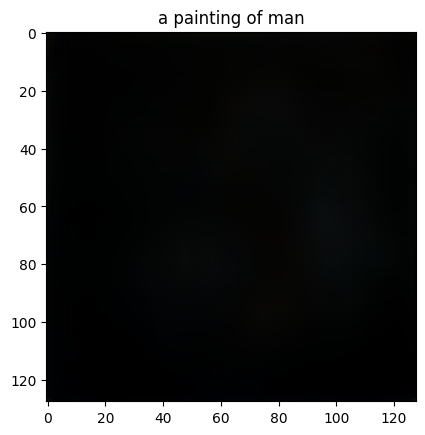

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

def generate_image(description, model, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([description])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    image_input = np.zeros((1, img_height, img_width, 3))  # Placeholder image input
    prediction = model.predict([image_input, padded_sequence])
    return prediction[0]
# Example usage
description = "a painting of man"
generated_image = generate_image(description, model, tokenizer, max_length)

plt.imshow(generated_image)
plt.title(description)
plt.show()
